# Loading image and libraries

In [90]:
!pip install scipy

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
from PIL import Image
import cv2  # Für Canny (muss installiert sein)

# Bild laden
bildpfad = "../images/shapes.png"
bild = Image.open(bildpfad).convert('L')
bild_array = np.array(bild)

# Overview

## Filter
Using convolution with a filter on a grayscale image, you can detect edges in an image. The value which is displayed in a grayscale image is the intensity (Helligkeit).
- Sobel → first derivative of the image (detects edges; partial derivative in x and y direction → sobel_x filter for vertical edges and sobel_y for horizontal edges)
- LaPlace → second derivative of the image (detects strong changes in intensity → often edges or corners)
- Gaussian → smoothing with a gaussian function

## Filter combinations

- Laplacian of Gaussian (LoG) = Laplace after Gauss
- Canny =
  1. smoothing (Gaussian)
  2. calculate gradients (Sobel Filter)
  3. Non-Maximum Suppression → thins out edges
  4. Hysteresis threshold → to select strong / weak edges


<a>
  <img src="../images/Effect-of-three-different-edge-detection-filters-Laplacian-Canny-and-Sobel-filters.png" alt="Pinhole camera" width="480" style="background-color: white;padding: 10px;">
</a>

<a href="https://www.youtube.com/watch?v=uNP6ZwQ3r6A" target="_blank">
<img src="https://img.youtube.com/vi/uNP6ZwQ3r6A/maxresdefault.jpg" alt="Simple Stereo" width="500">
</a>

# Sobel (Derivative of Gaussian with $\sigma = 1$)

<a>
  <img src="../images/Sobel_operator.webp" alt="Pinhole camera" width="480" style="background-color: white;padding: 10px;">
</a>

Der Sobel-Operator ist ein Kantendetektor aus der Bildverarbeitung. Er berechnet die ungefähre Ableitung (Gradient) eines Bildes in x- und y-Richtung. So lassen sich Kanten (plötzliche Helligkeitswechsel) erkennen. Da das Ergebnis jedoch empfindlich gegenüber Rauschen ist, wird noch eine leichte Glättung hinzugefügt. 

>Der Sobelfilter ist also eine Kombination aus:
>- Approximation der ersten Ableitung
>- Leichter Glättung

Die erste Ableitung berechnet sich aus:
$$f’(x)=\frac{d f(x)}{dx}$$

Im Bildverarbeitungskontext arbeitest du aber mit diskreten Pixeln, also kannst du die Ableitung nur näherungsweise berechnen.
$$f’(x) \approx \frac{f(x+h) - f(x-h)}{2h}$$

Wenn wir h = 1 setzen (Abstand zwischen den Pixeln), vereinfacht sich das zu:

$$f’(x) \approx \frac{f(x+1) - f(x-1)}{2}$$

Das ist die zentrale Differenzenmethode. In Kernel-Form sieht das so aus:
$$\begin{bmatrix}
-0.5  & 0 & 0.5\\
\end{bmatrix}$$

➡️ Die Sobel-Operatoren sind Faltungsmatrizen (Kernels), die über das Bild gelegt werden:

Sobel X (horizontale Kanten):

$$G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{bmatrix}$$

Sobel Y (vertikale Kanten):

$$G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 &  0 &  0 \\
1 &  2 &  1 \\
\end{bmatrix}$$

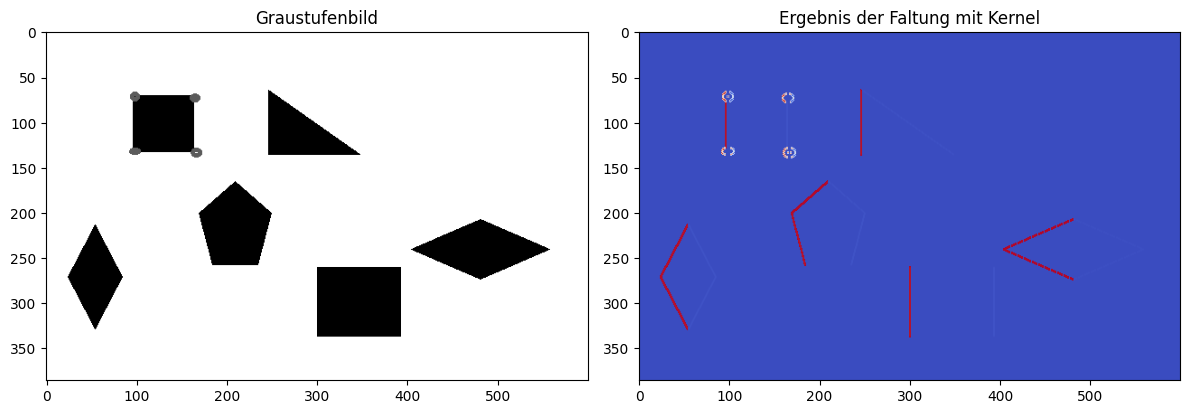

In [92]:
# Filter definieren
# Hier verwenden wir den klassischen Sobel X Kernel
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='coolwarm')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

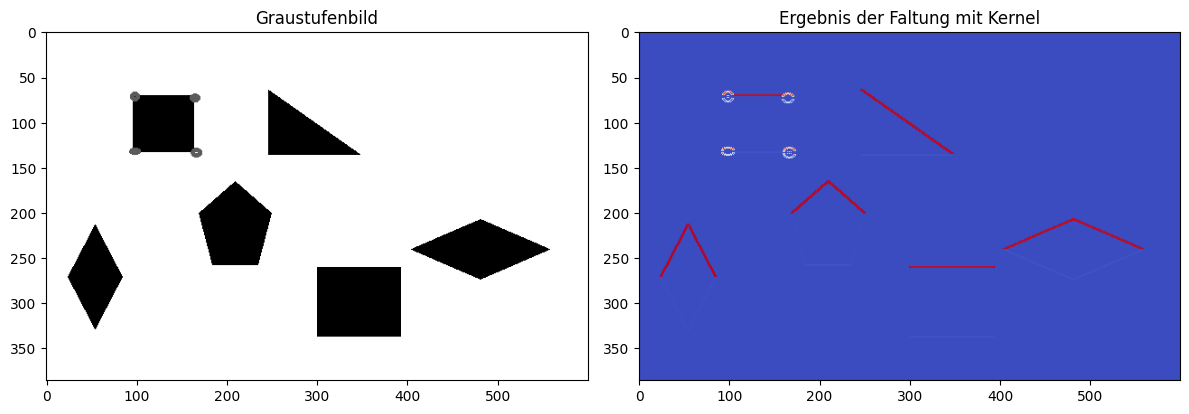

In [93]:
# Filter definieren
# Hier verwenden wir den klassischen Sobel Y Kernel
kernel = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='coolwarm')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

Nachdem das Graustufenbild mit Sobel einmal in X-Richtung und einmal in Y-Richtung gefaltet wurde, werden die Ergebnisse addiert.

$\text{Magnitude} = \sqrt{(S_x)^2 + (S_y)^2}$

Der Sobel-Magnitude-Operator lässt sich nicht als einzelner Kernel darstellen, weil er die Kombination aus zwei Kerneln (für x- und y-Richtung) ist und erst nach der Faltung mit beiden Kerneln die Magnitude berechnet wird.

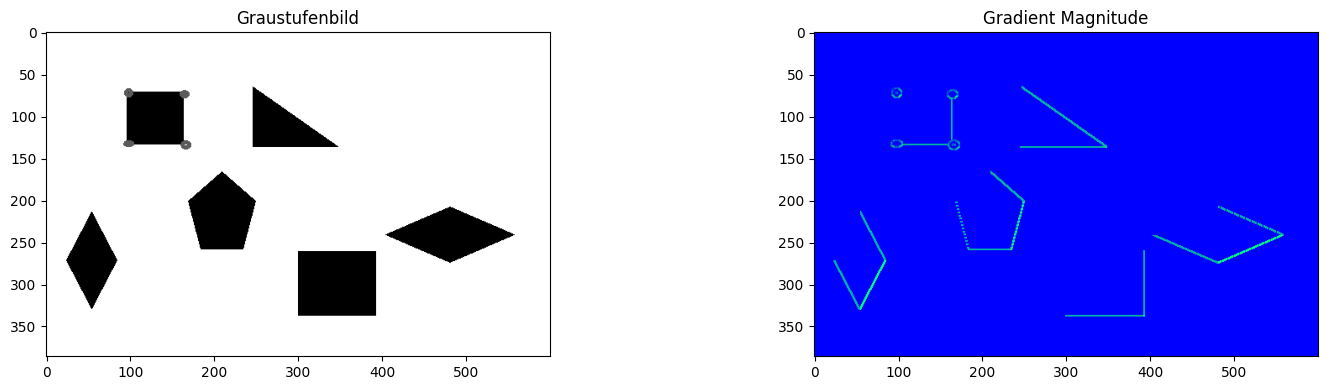

In [94]:
from scipy import ndimage

# Sobel-Operator anwenden
sobel_x = ndimage.sobel(bild_array, axis=1)
sobel_y = ndimage.sobel(bild_array, axis=0)
sobel_magnitude = np.hypot(sobel_x, sobel_y)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(sobel_magnitude, cmap='winter')
axs[1].set_title("Gradient Magnitude")

plt.tight_layout()
plt.show()

Grundsätzlich ist der Sobel-Operator ein spezieller Kantendetektor, der als diskreter Filter (Kernel) definiert ist und typischerweise auf Bilddaten oder diskrete 2D-Daten angewendet wird.

**Kann man den Sobel-Operator auch auf eine kontinuierliche Funktion anwenden?**

Nicht direkt analytisch, weil der Sobel-Operator auf der diskreten Approximation der Ableitung basiert. Aber was du machen kannst (und was oft gemacht wird):

✅ Du wertest deine Funktion diskret auf einem Gitter aus (so wie du es mit deiner Sinus-Cosinus-Funktion gemacht hast)

✅ Dann kannst du den Sobel-Operator ganz genauso wie auf ein Bild anwenden, weil du ja ein 2D-Array hast

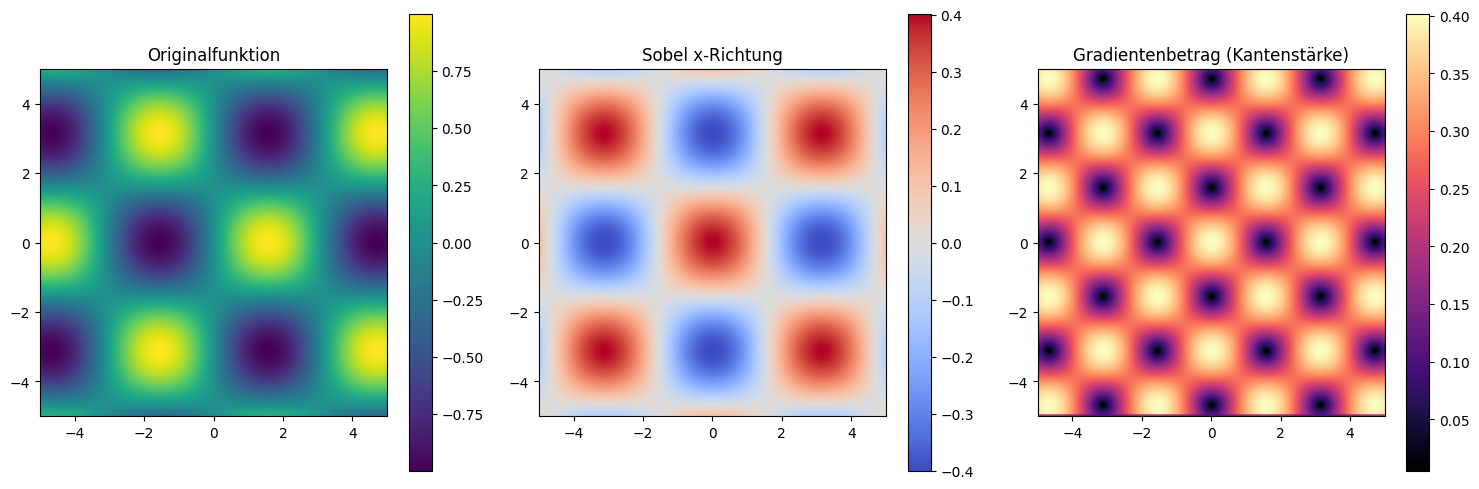

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

# Gitter erzeugen
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)

# Funktion definieren
Z = np.sin(X) * np.cos(Y)

# Sobel-Operator anwenden (Ableitungen in x- und y-Richtung)
sobel_x = sobel(Z, axis=1)
sobel_y = sobel(Z, axis=0)
gradient_magnitude = np.hypot(sobel_x, sobel_y)

# Plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

im0 = axs[0].imshow(Z, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
axs[0].set_title("Originalfunktion")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(sobel_x, extent=(-5, 5, -5, 5), origin='lower', cmap='coolwarm')
axs[1].set_title("Sobel x-Richtung")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(gradient_magnitude, extent=(-5, 5, -5, 5), origin='lower', cmap='magma')
axs[2].set_title("Gradientenbetrag (Kantenstärke)")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

# LaPlace

Der Laplace-Operator ist definiert als die Summe der zweiten Ableitungen einer Funktion:

- Für eine Funktion f(x, y) im 2D-Raum ist:
$$\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$$

- In 3D:
$$\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2}$$

---
✅ Der Gradient einer Funktion liefert einen Vektor, der die Richtung und Stärke des größten Anstiegs beschreibt. Das ist die erste Ableitung.

✅ Der Laplace-Operator ist die Summe der zweiten partiellen Ableitungen, also ein Maß dafür, wie stark die Funktion in alle Richtungen “gekrümmt” ist.

$$\Delta f = \nabla \cdot \nabla f = \text{div}(\text{grad}(f))$$

Das heißt:
- Du bildest zuerst den Gradient (erste Ableitungen → Vektor).
- Dann nimmst du die Divergenz dieses Gradienten (Summe der partiellen Ableitungen der Gradienten-Komponenten).

Fazit:
Der Laplace-Operator ist also nicht der “zweite Gradient”, sondern die Divergenz des Gradienten, was die Summe der zweiten Ableitungen ergibt.

---- 

In der Bildverarbeitung wird der diskrete Laplace-Operator oft als Filter-Maske angewandt, um Kanten oder schnelle Helligkeitswechsel zu erkennen. 

**Herleitung**
Für ein Bild benötigen wir den LaPlace Operator im 2D-Raum. 

1. Die zweite Ableitung in x-Richtung (diskret) lautet:

    $\frac{\partial^2 f}{\partial x^2} \approx f(x+1, y) - 2f(x, y) + f(x-1, y)$

2. Genauso in y-Richtung:

    $\frac{\partial^2 f}{\partial y^2} \approx f(x, y+1) - 2f(x, y) + f(x, y-1)$

3. Wenn du das zusammenfasst, erhältst du den klassischen 4-neighbourhood 2D-Laplace-Kernel, bei dem nur die direkten Nachbarn berücksichtigt werden: 
$$\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}$$

4. Um resistenter gegen Rotationen zu sein, kann der 8-neighbourhood Laplace-Kernel verwendet werden, der auch Diagonalen berücksichtigt.

$$\begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1
\end{bmatrix}$$

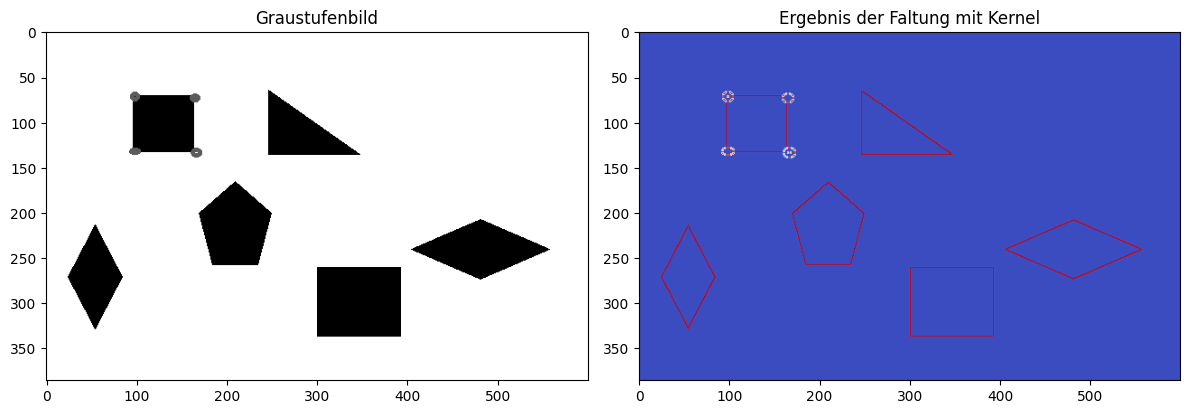

In [95]:
# Filter definieren
# Hier verwenden wir den klassischen 8-neighbourhood Laplace-Kernel
kernel = np.array([[1, 1, 1],
                   [1, -8, 1],
                   [1, 1, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='coolwarm')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

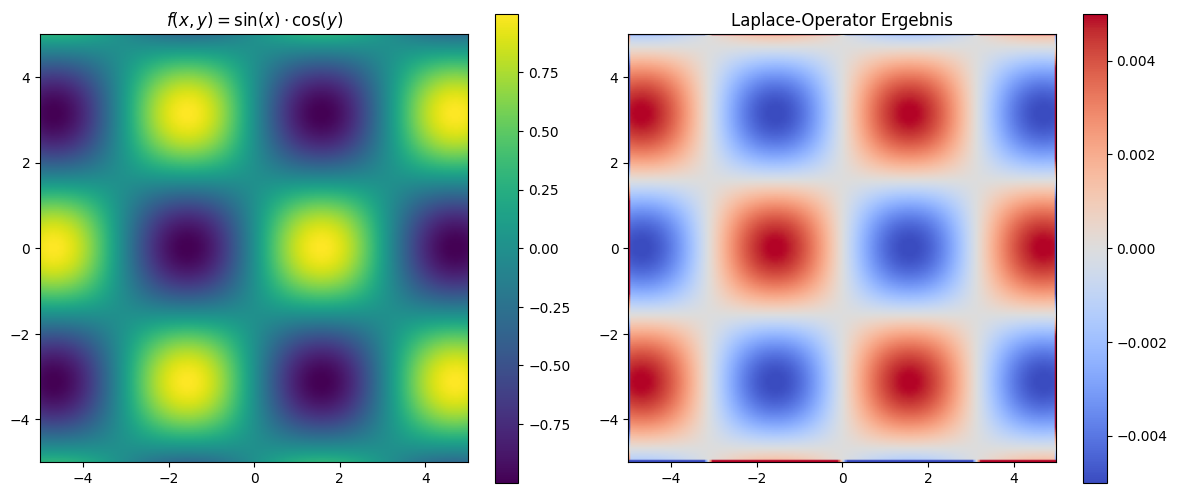

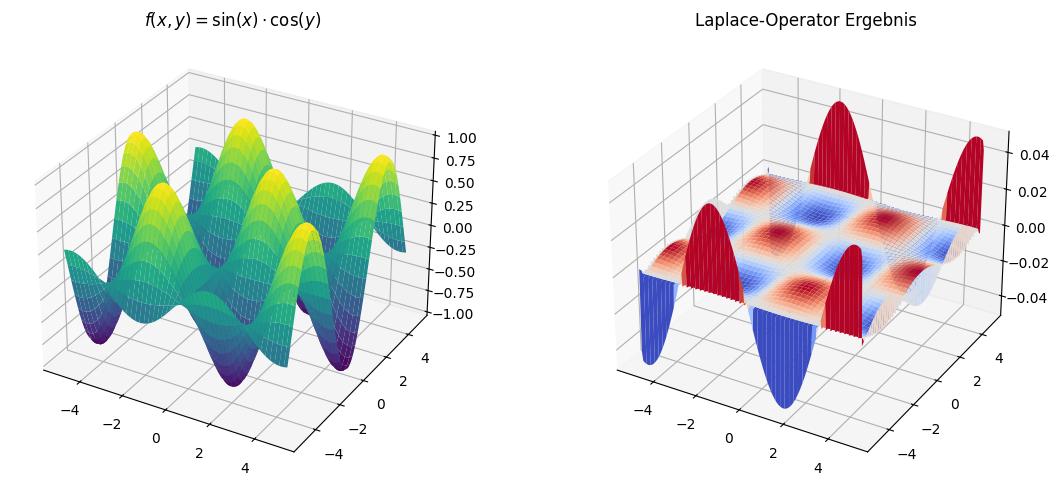

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

# Gitter erzeugen
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)

# Komplexere Funktion: Sinus-Cosinus-Kombination
Z = np.sin(X) * np.cos(Y)
#Z = np.array(bild) # auskommentieren für Beispiel: Graustufenbild als Funktion

# Laplace-Operator anwenden
laplace_Z = laplace(Z)

# Plotten
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Originalfunktion
im0 = axs[0].imshow(Z, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
axs[0].set_title(r"$f(x,y) = \sin(x) \cdot \cos(y)$")
plt.colorbar(im0, ax=axs[0])

# Laplace-Operator Ergebnis
im1 = axs[1].imshow(laplace_Z, extent=(-5, 5, -5, 5), origin='lower', cmap='coolwarm', vmin=-0.005, vmax=0.005)
axs[1].set_title("Laplace-Operator Ergebnis")
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

# 3D-Plots
fig = plt.figure(figsize=(12, 5))

# Originalfunktion
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_title(r"$f(x,y) = \sin(x) \cdot \cos(y)$")

# Ergebnis nach Laplace-Operator
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, laplace_Z, cmap='coolwarm', vmin=-0.005, vmax=0.005)
ax2.set_title("Laplace-Operator Ergebnis")

plt.tight_layout()
plt.show()

Was du erkennen solltest:

✅ Die Laplace-Berechnung hebt besonders die Stellen hervor, an denen die Krümmung der Funktion wechselt.

✅ Maxima erscheinen negativ, Minima positiv (je nach Konvention). → Die zweite Ableitung von `sin(x)` ist `-sin(x)`

✅ Die wellenartige Struktur bleibt im Laplace-Bild sichtbar, aber zeigt dort die “zweite Ableitung” der Funktion.

✅ Links siehst du die wellenartige Struktur der Sinus-Cosinus-Funktion.

✅ Rechts siehst du, wie der Laplace-Operator die Krümmungsinformationen extrahiert. Maxima, Minima und Sattelstellen werden durch unterschiedliche Farben hervorgehoben.

**Warum sind die Minima/Maxima schwach?**
1.	Numerische Approximation:
Der scipy.ndimage.laplace Operator verwendet numerische Filter (finite differences), die am Rand stärkere Artefakte erzeugen. Die echten Krümmungen im Inneren erscheinen oft schwächer.

2.	Die Funktion selbst:
Bei einer Funktion wie sin(x) * cos(y) wechseln sich positive und negative Bereiche regelmäßig ab. An vielen Stellen kompensiert sich die Krümmung, weshalb der Laplace-Wert nahe Null bleibt. Die Extremwerte sind nur an bestimmten Punkten deutlich.

3.	Farbschema / Skalierung:
Standardmäßig skaliert plot_surface die Farbtöne automatisch auf die Minimal- und Maximalwerte. Wenn die Werte im Inneren sehr nah an Null liegen und nur am Rand starke Ausschläge vorhanden sind, erscheinen die inneren Unterschiede fast unsichtbar.

    → angepasste Farbskala:     
    `ax2.plot_surface(X, Y, laplace_Z, cmap='coolwarm', vmin=-0.5, vmax=0.5)`

# Gaussian

### 1D Gaussian function

<a>
  <img src="../images/1D_gaussian_function.png" alt="Pinhole camera" width="500" style="background-color: white;padding: 10px;">
</a>

Anhand der 1D Gaussfunktion sollen die Effekte der einzelnen Parameter untersucht werden.

- $ A $ ändert die Höhe

- $ \mu $ verschiebt den Ursprung

- $ \sigma $ verändert die Breite der Glocken/Gausskurve (Standarabweichung)


### 2D Gaussian function

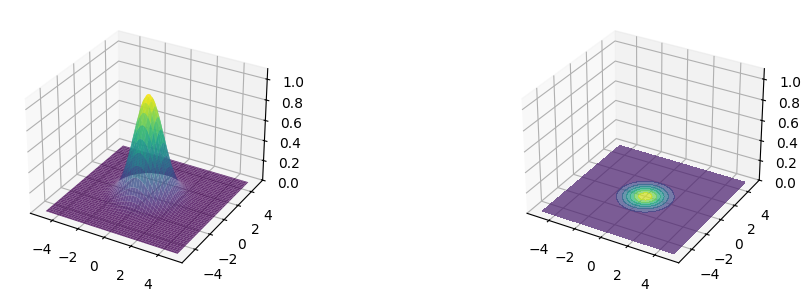

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
A = 1
x0, y0 = 0, 0
sigma_x = 1
sigma_y = 1

# Grid
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# 2D Gaussian
Z = A * np.exp(-(((X - x0)**2) / (2 * sigma_x**2) + ((Y - y0)**2) / (2 * sigma_y**2)))

# Plot
fig = plt.figure(figsize=(12, 3))

# 3D Surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# 2D Contour projection auf die x-y-Ebene bei z=0
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap='viridis', alpha=0.7)

# Achsen
ax1.set_zlim(0, A*1.1)
ax2.set_zlim(0, A*1.1)
plt.tight_layout()
plt.show()

The 2D Gaussian function is given by: 
$$G(x, y) = A \cdot \exp\left( -\left( \frac{(x - x_0)^2}{2\sigma_x^2} + \frac{(y - y_0)^2}{2\sigma_y^2} \right) \right)$$

Where:
- $A$ = Amplitude (peak value)
- $(x_0, y_0)$ = Center of the Gaussian
- $\sigma_x, \sigma_y$ = Standard deviations in x and y direction

The Kernel is calculated by approximation. Imagine a 3x3 grid ranging x-values from [-1,0,1] and y-values from [-1,0,1]. 

For each coordinate $G(x_1,y_1)$ the gaussian value can be calculated. 

$$ \frac{1} {16} 
\cdot \begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
= 
\begin{bmatrix}
0.075 & 0.124 & 0.075 \\
0.124 & 0.204 & 0.124 \\
0.075 & 0.124 & 0.075
\end{bmatrix}
$$

For example with $A=1$, $\sigma=0,85$ and $(x_0, y_0)=(0,0)$: 
$$G(x=0,y=1)=1\cdot e^{-((\frac{(0-0)^2}{2\cdot 0.85^2})+(\frac{(1-0)^2}{2\cdot 0.85^2}))}=e^{-\frac{1}{2\cdot 0.85^2}}$$


 Wieso kann ich den Kernel nicht händisch ausrechnen?

In [119]:
import numpy as np

def gaussian(x, y, A=1, x0=0, y0=0, sigma=1):
    return A * np.exp(-(((x - x0)**2 + (y - y0)**2) / (2 * sigma**2)))

# Beispielwert
val = gaussian(0, 1)
print(f"G(0,1) = {val:.4f}")  # Erwartet: ca. 0.6065

G(0,1) = 0.6065


In [121]:
# 3x3 Kernel um (0,0) mit sigma=1
size = 1  # Radius
kernel = np.zeros((2*size+1, 2*size+1))
for i, x in enumerate(range(-size, size+1)):
    for j, y in enumerate(range(-size, size+1)):
        kernel[i, j] = gaussian(x, y)

# Kernel normalisieren
kernel /= np.sum(kernel)

print("3x3 Gaussian Kernel:")
print(kernel)

3x3 Gaussian Kernel:
[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


In [123]:
import numpy as np

def gaussian_kernel(size=3, sigma=1.0, A=1.0, normalize=True):
    """
    Berechnet einen 2D-Gaussian Kernel.
    
    Args:
        size (int): Größe des Kernels (muss ungerade sein, z.B. 3, 5, 7)
        sigma (float): Standardabweichung der Gaußfunktion
        A (float): Amplitude der Gaußfunktion
        normalize (bool): Ob der Kernel normiert werden soll (Summe=1)
    
    Returns:
        np.ndarray: Gaussian Kernel
    """
    assert size % 2 == 1, "Kernelgröße muss ungerade sein"
    ax = np.arange(-(size // 2), size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    kernel = A * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    if normalize:
        kernel = kernel / np.sum(kernel)
    
    return kernel

# Beispiel
kernel = gaussian_kernel(size=3, sigma=1.0, A=1.0)
print("Gaussian Kernel (3x3) mit sigma=1.0, A=1.0:\n", kernel)
print("Summe Kernel:", np.sum(kernel))

Gaussian Kernel (3x3) mit sigma=1.0, A=1.0:
 [[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
Summe Kernel: 0.9999999999999998


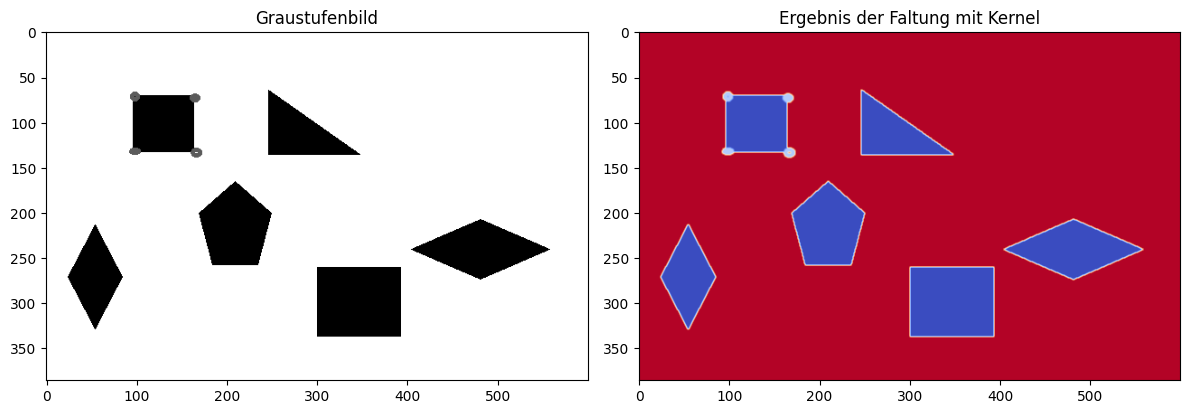

In [131]:
# Filter definieren
# Hier verwenden wir den 
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])/ 16
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='coolwarm')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

# Derivative of Gaussian

Die Derivative of Gaussian (DoG) ist die erste Ableitung der Gaußfunktion und wird verwendet, um Kanten in Bildern zu detektieren, während gleichzeitig Rauschen unterdrückt wird. Sie kombiniert also Glättung (Gaussian) und Kantendetektion (Ableitung) in einem Schritt.

⸻

📌 Mathematische Definition

Die 2D-Gaußfunktion lautet:
$$G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Die erste Ableitung nach x (Partielle Ableitung):
$$\frac{\partial G(x, y)}{\partial x} = -\frac{x}{2\pi\sigma^4} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Analog nach y:
$$\frac{\partial G(x, y)}{\partial y} = -\frac{y}{2\pi\sigma^4} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Diese Ableitungen können als Filter-Kernel verwendet werden (ähnlich wie Sobel, aber geglättet).

💡 Vorteil gegenüber Sobel:
- Sobel = einfache Ableitung + wenig Glättung
- DoG = mathematisch exakte Ableitung + anpassbare Glättung (über σ)

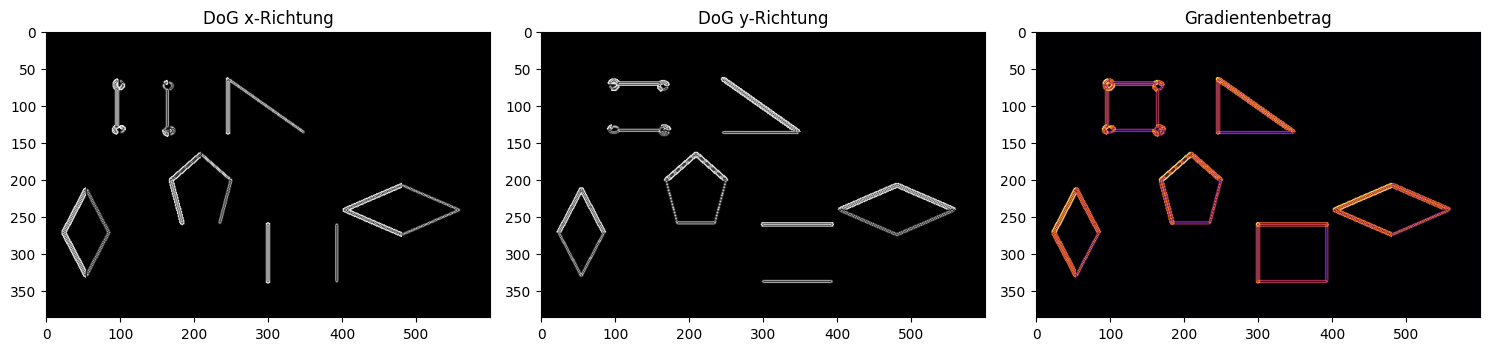

In [132]:
def derivative_of_gaussian(size=5, sigma=1.0, direction='x'):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)

    gauss = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    if direction == 'x':
        dog = -xx * gauss / (sigma**2)
    elif direction == 'y':
        dog = -yy * gauss / (sigma**2)
    else:
        raise ValueError("direction must be 'x' or 'y'")
    
    # Optional: normieren
    dog -= np.mean(dog)
    return dog

# DoG-Filter erzeugen
dog_x = derivative_of_gaussian(size=7, sigma=1.0, direction='x')
dog_y = derivative_of_gaussian(size=7, sigma=1.0, direction='y')

# Filter anwenden
gradient_x = convolve(bild_array, dog_x)
gradient_y = convolve(bild_array, dog_y)
magnitude = np.hypot(gradient_x, gradient_y)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gradient_x, cmap='gray')
axs[0].set_title("DoG x-Richtung")
axs[1].imshow(gradient_y, cmap='gray')
axs[1].set_title("DoG y-Richtung")
axs[2].imshow(magnitude, cmap='inferno')
axs[2].set_title("Gradientenbetrag")
plt.tight_layout()
plt.show()

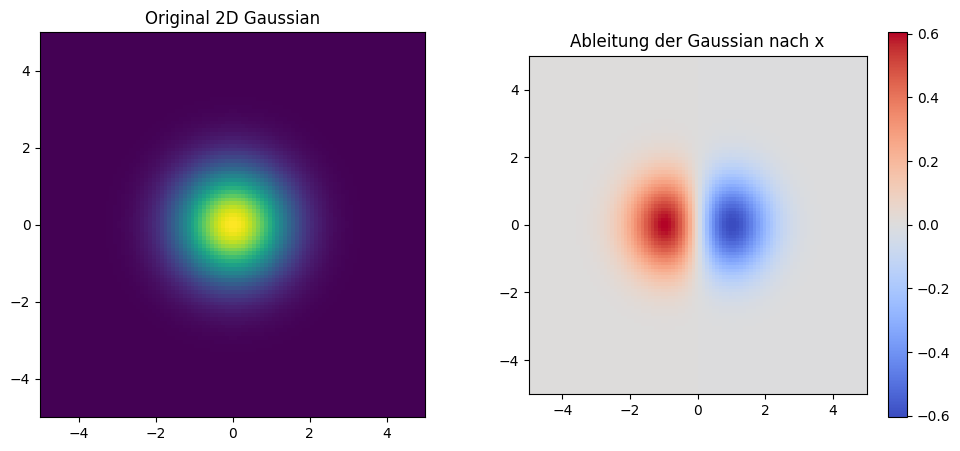

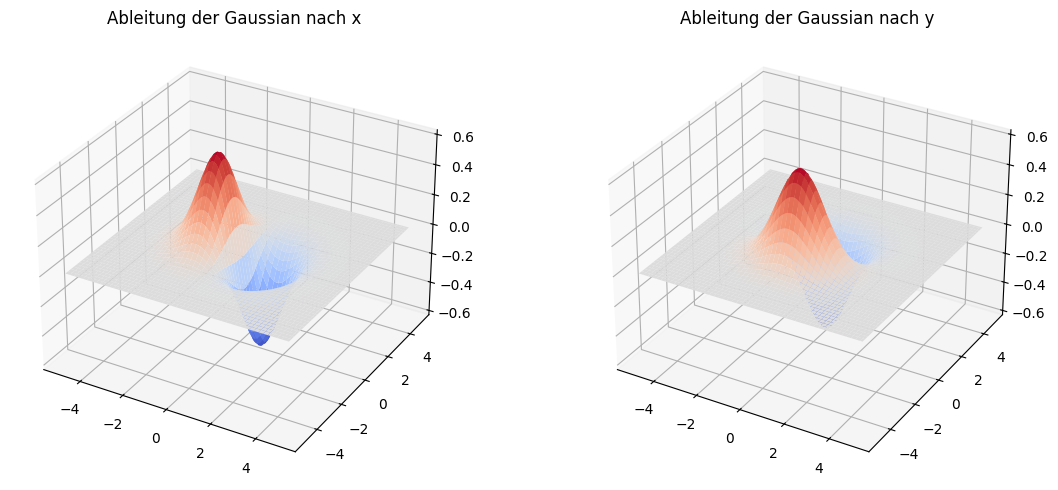

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
sigma = 1
A = 1

# Gitter erzeugen
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# 2D Gaussian
Z = A * np.exp(- (X**2 + Y**2) / (2 * sigma**2))

# Ableitung der Gaussian nach x
dZ_dx = - (X / sigma**2) * Z
dZ_dy = - (Y / sigma**2) * Z

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Original Gaussian
axs[0].imshow(Z, extent=[-5,5,-5,5], origin='lower', cmap='viridis')
axs[0].set_title('Original 2D Gaussian')

# Ableitung nach x
im = axs[1].imshow(dZ_dx, extent=[-5,5,-5,5], origin='lower', cmap='coolwarm')
axs[1].set_title('Ableitung der Gaussian nach x')
plt.colorbar(im, ax=axs[1])
plt.show()

# 3D Plot
fig = plt.figure(figsize=(12, 5))

# 3D Surface Plot der Ableitung nach x
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, dZ_dx, cmap='coolwarm')
ax1.set_title("Ableitung der Gaussian nach x")

# 3D Surface Plot der Ableitung nach y
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, dZ_dy, cmap='coolwarm')
ax2.set_title("Ableitung der Gaussian nach y")

plt.tight_layout()
plt.show()

# LoG (Laplacian of Gaussian)

$$\text{LoG}(x, y) = \nabla^2 G(x, y)$$
= Laplace (zweite Ableitung) der Gaußfunktion G(x, y)

LoG kombiniert zwei Dinge:
1.	Glättung mit einer Gaußfunktion → unterdrückt Rauschen
2.	Kantendetektion durch den Laplace-Operator → findet starke Helligkeitsänderungen (zweite Ableitung)
    
→ LoG detektiert Kanten robuster als der Laplace-Operator allein, da er vorher glättet!


**Herleitung (konzeptionell)**
1.	Die Gaußfunktion ist:
$$G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$$
2.	Die Laplacian-Operator ist:
$$\nabla^2 G = \frac{\partial^2 G}{\partial x^2} + \frac{\partial^2 G}{\partial y^2}$$
3.	Das ergibt (abgeleitet!):
$$\nabla^2 G(x, y) = \left(\frac{x^2 + y^2 - 2\sigma^2}{\sigma^4}\right) \cdot G(x, y)$$

🔁 Du wendest erst die Gauß-Glättung an, dann den Laplace-Filter — oder nutzt direkt einen vordefinierten LoG-Kernel.

⸻

🧪 Beispiel-Kernel (5×5, σ ≈ 1.0):

$$\begin{bmatrix}
0 & 0 & -1 & 0 & 0 \\
0 & -1 & -2 & -1 & 0 \\
-1 & -2 & 16 & -2 & -1 \\
0 & -1 & -2 & -1 & 0 \\
0 & 0 & -1 & 0 & 0 \\
\end{bmatrix}$$

Der 3x3 LoG Kernel sieht genauso aus wie der 3x3 LaPlace Kernel. Für echte LoG-Kernel braucht man typischerweise größere Größen (5x5 oder 7x7), da die Gauß-Glättung eine Verteilung mit mehreren Werten hat.

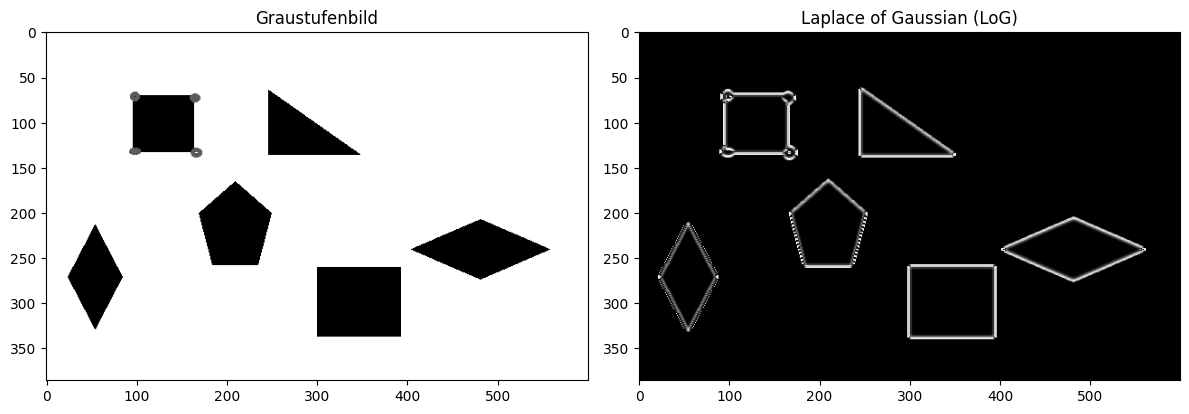

In [134]:
from scipy.ndimage import gaussian_laplace

log_bild = gaussian_laplace(bild_array, sigma=1.0)
# Plotten
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  
axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")
axs[1].imshow(log_bild, cmap='gray')
axs[1].set_title("Laplace of Gaussian (LoG)")
plt.tight_layout()
plt.show()

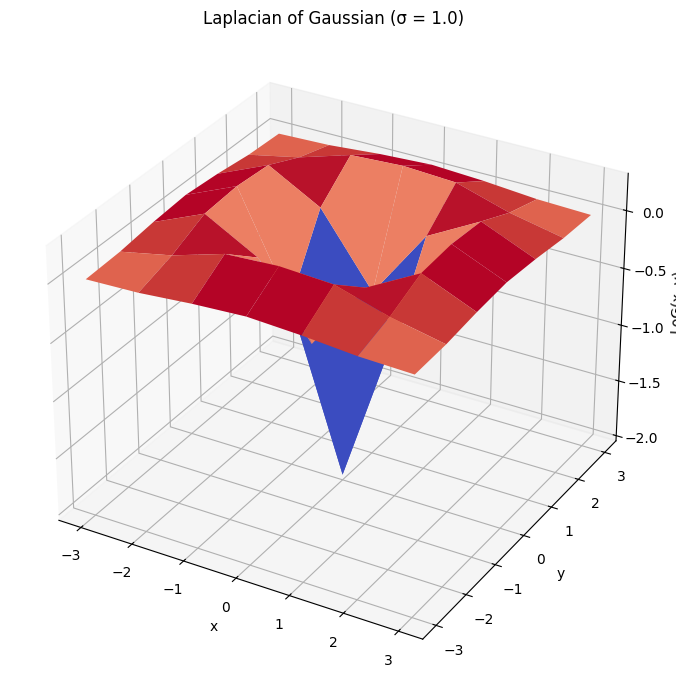

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def laplacian_of_gaussian(x, y, sigma):
    """Berechnet den LoG-Wert an Position (x, y) für gegebenes sigma"""
    r2 = x**2 + y**2
    factor = (r2 - 2 * sigma**2) / (sigma**4)
    gaussian = np.exp(-r2 / (2 * sigma**2))
    return factor * gaussian

# Parameter
sigma = 1.0
size = int(6 * sigma) + 1  # Kernelgröße (symmetrisch um Null)
half_size = size // 2

# Gitter erstellen
x = np.linspace(-half_size, half_size, size)
y = np.linspace(-half_size, half_size, size)
X, Y = np.meshgrid(x, y)
Z = laplacian_of_gaussian(X, Y, sigma)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm')
ax.set_title(f"Laplacian of Gaussian (σ = {sigma})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("LoG(x, y)")

plt.tight_layout()
plt.show()